# Atlassian Confluence Wikipedia mit Apache Solr

## Import der Libraries

In [1]:
%matplotlib inline
from langdetect import DetectorFactory, detect, detect_langs
import time, re, requests, json, sqlite3
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import torch
import sqlite3

## Datenbeschaffung

In [3]:
def get_details(page_id,sessionKey):
    host="https://wiki.swisscom.com"
    key = sessionKey
    body = requests.get(host+'/rest/api/content/'+page_id+'?expand=body.storage', cookies={'JSESSIONID': key}).json()
    body_storage_value = body['body']['storage']['value']
   
    body_title = body['title']
    version = requests.get(host+'/rest/experimental/content/'+ page_id +'/version', cookies={'JSESSIONID': key}).json()
    
    version_results_displayName = version['results'][0]['by']['displayName']
    version_results_when = version['results'][0]['when'].split('T')[0]
    version_numEdits = len(version['results'])
    version_space = body['_expandable']['space'].split('/')[-1]
    df_details = pd.DataFrame([{'pageID':page_id,'body':body_storage_value,'Title': body_title,'Editor':version_results_displayName,'Datum':version_results_when,'numEdits':version_numEdits,'Space':version_space}])
    print(body_title)
    
    return df_details

def get_pageContentById(idlist, output, sessionKey):
    host="https://wiki.swisscom.com"
    root = idlist
    key = sessionKey
    content = pd.DataFrame()
    

    for i in root:
        for c0 in requests.get(host+'/rest/api/content/'+ i +'/child/page', cookies={'JSESSIONID': key}).json()["results"]:
            content = content.append(get_details(c0["id"],sessionKey),ignore_index=True)
            for c1 in requests.get(host+'/rest/api/content/'+ c0["id"] +'/child/page', cookies={'JSESSIONID': key}).json()["results"]:
                content = content.append(get_details(c1["id"],sessionKey),ignore_index=True)
                for c2 in requests.get(host+'/rest/api/content/'+ c1["id"] +'/child/page', cookies={'JSESSIONID': key}).json()["results"]:
                    content = content.append(get_details(c2["id"],sessionKey),ignore_index=True)
    content.to_csv(output)

if __name__ == '__main__':
    model_path = 'model'
    idlist = ["495411368","436153540","146239846","169911290","113547092","149572934","203851850","81955980","419584253","510376245","158841416","208322737","149573717","237577487","453225783","223849290","209635254","213464808","276398011","179036406","55821099"]
    output = './confluence_data.csv'
    sessionKey = "sessionkey"
    get_pageContentById(idlist,output,sessionKey)

## Data Cleansing

In [180]:
# Function to remove all HTML Tags
def cleanhtml(raw_html="none"):
    cleantext = re.sub('<.*?>','', str(raw_html))
    return cleantext

In [237]:
def cleanSpecialCharacters(df_confluence):
    text.pop('Unnamed: 0')
    text['body'] = text.apply(lambda row : cleanhtml(row['body']), axis = 1)
    text = text.replace(r'\n',' ', regex=True)
    text = text.replace(r'&ndash',' ')
    text = text.replace(r'&nbsp',' ')
    text = text.replace(r'&quot',' ')
    text = text.replace(r'&mdash',' ')
    text = text.replace(r'&amp',' ')
    text = text.replace(r'[@()*]+', ' ', regex=True)
    return text

## Explorative Datenanalyse

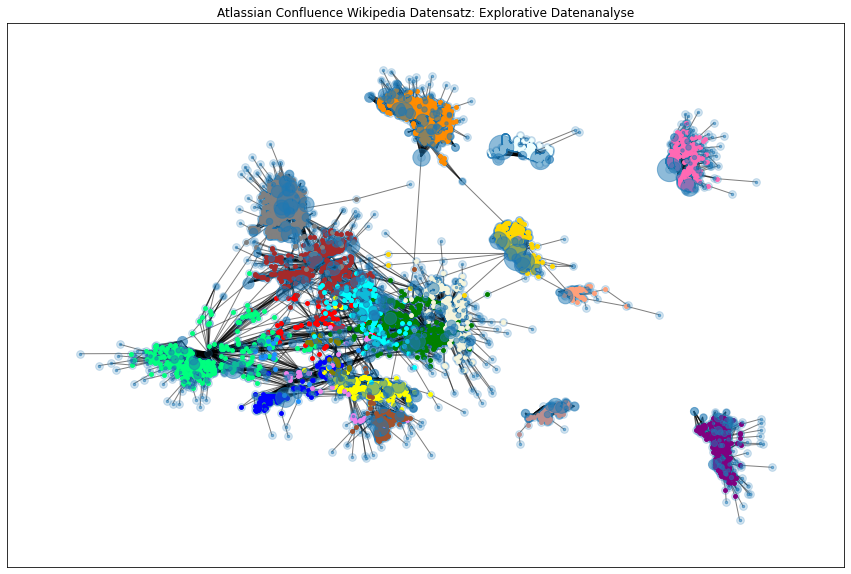

In [411]:
def showKnowledgeGraph(df_confluence):
    plt.rcParams['figure.figsize'] = [15, 10]
    field = 'Editor'
    G = nx.Graph()
    for id,content in df_confluence.iterrows():
        G.add_edge(content['pageID'],content[field].split(',')[0])
        G.add_edge(content['pageID'],content['Space'])
    plt.title(field)
    pos = nx.spring_layout(G, k=0.0015, iterations=30)

    color = ['blue','green','yellow','red','brown','springgreen','violet','green','azure','purple','grey', 'olive', 'aqua', 'hotpink','dodgerblue','sienna','beige','rosybrown','gold','darkorange','lightsalmon']
    G_space = nx.Graph()
    degrees = dict(G.degree())
    nx.draw_networkx_nodes(G.nodes(),pos,node_size=60,alpha=0.2)
    nx.draw_networkx_edges(G_space,pos,edgelist=G.edges(),alpha=0.5)
    for index,space in enumerate(df_confluence.Space.unique()):
        G_space = nx.Graph()
        G_space.add_nodes_from([i.pageID for s,i in df_confluence.iterrows() if i.Space == space])
        nx.draw_networkx_edges(G_space, pos, edge_color='blue')
        nx.draw_networkx_nodes(G_space, pos, node_size=15, node_color=color[index])

    for e in df_confluence.Editor.unique():
        G_editor = nx.Graph()
        G_editor.add_node(e)
        nx.draw_networkx_nodes(G_editor, pos, alpha=0.5, node_size=degrees[e]*6)

    plt.title('Atlassian Confluence Wikipedia Datensatz: Explorative Datenanalyse')
    plt.show()    

showKnowledgeGraph(df_confluence)

# Datenveredelung

### Sprache erkennen

In [203]:
to_detectLanguage = pd.read_csv('confluence_data.csv')

# Conncect to Database
con.commit()
con.close()
con = sqlite3.connect('to_detectLanguage.db')
cur = con.cursor()
df_confluence.to_sql(name='confluence', con=con)

In [207]:
to_detectLanguage = cleanSpecialCharacters(to_detectLanguage)

In [236]:
def detectLanguage(df_confluence):
    for index,row in to_detectLanguage.iterrows():
        body_storage_value = row.body
        body_language = 'None'
        if(body_storage_value):
            body_language = detect(body_storage_value)   
        cur.execute('UPDATE confluence SET Sprache = "'+body_language+'" WHERE pageID ='+str(row.pageID)+';')
        con.commit()

        print(index," ",row.pageID, body_language, ": " ,end - start)

In [ ]:
to_detectLanguage[0:5]

### Übersetzung

In [ ]:
!git clone https://github.com/pytorch/fairseq
!cd fairseq

In [ ]:
def translateToGerman(df_confluence):
    for index,row in to_translate.iterrows():
        start = time.time()
        body_enum = re.sub(r'(@\[A-Za-z0-9]+)|([^0-9A-Za-z. \t])|(\w+:\/\/\S+)|^rt|http.+?', '', str(row.body))
        translated = [en2de.translate(i[0:1024], beam=1) for i in str(body_enum).split('.')[0:5]]
        body_de = ','.join(translated)
        body_de = body_de.replace('"','')
        end = time.time()
        while True:
            try:
                cur.execute('UPDATE confluence SET body_de = "'+str(body_de)+'" WHERE pageID ='+str(row.pageID)+';')
                con.commit()
                break
            except Exception as e:
                print(row,'\n',body_de_enum, body_de, '\n',e)

        print(row['index'], index," ",row.pageID, ": " ,end - start)


In [ ]:
en2de = torch.hub.load('pytorch/fairseq', 'transformer.wmt19.en-de.single_model')

In [18]:
en2de.translate('Hello world', beam=5)

'Hallo Welt'

In [243]:
# Conncect to Database
con.commit()
con.close()
con = sqlite3.connect('example.db')
cur = con.cursor()

In [51]:
cur.execute('DROP TABLE IF EXISTS confluence;')

In [52]:
# Create Database conluence
df_confluence.to_sql(name='confluence', con=con)

/Users/nussbaumer/Library/Python/3.8/lib/python/site-packages/pandas/core/generic.py:2872: UserWarning: The spaces in these column names will not be changed. In pandas versions < 0.14, spaces were converted to underscores.
  sql.to_sql(


In [53]:
cur.execute('ALTER TABLE confluence ADD body_de text;')

In [ ]:
for index,row in to_translate.iterrows():
    start = time.time()
    body_enum = re.sub(r'(@\[A-Za-z0-9]+)|([^0-9A-Za-z. \t])|(\w+:\/\/\S+)|^rt|http.+?', '', str(row.body))
    translated = [en2de.translate(i[0:1024], beam=1) for i in str(body_enum).split('.')[0:5]]
    body_de = ','.join(translated)
    body_de = body_de.replace('"','')
    end = time.time()
    while True:
        try:
            cur.execute('UPDATE confluence SET body_de = "'+str(body_de)+'" WHERE pageID ='+str(row.pageID)+';')
            con.commit()
            break
        except Exception as e:
            print(row,'\n',body_de_enum, body_de, '\n',e)
    
    print(row['index'], index," ",row.pageID, ": " ,end - start)



In [ ]:
df_confluence = pd.read_sql("SELECT * FROM confluence",con)
df_confluence

In [100]:
to_translate = pd.read_sql("SELECT * FROM confluence WHERE body_de IS NULL OR body_de = ''",con)
to_translate

,index,Unnamed: 0,pageID,body,Title,Editor,Datum,numEdits,Space,Sprache,body_de


In [90]:
inhalt.to_csv('confluence_withtranslation.csv')

# Data analysis

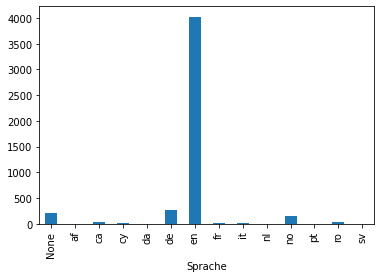

In [226]:
inhalt.groupby('Sprache').size().plot.bar()
plt.show()

In [234]:
print(inhalt.groupby('Sprache').size())

Sprache
None     219
af         2
ca        29
cy         6
da         2
de       272
en      4024
fr         8
it         6
nl         4
no       143
pt         1
ro        33
sv         1
dtype: int64


In [228]:
print(inhalt.count())

index         4750
Unnamed: 0    4750
pageID        4750
body          4204
Title         4750
Editor        4750
Datum         4750
numEdits      4750
Space         4750
Sprache       4750
body_de       4750
dtype: int64


In [232]:
print(list(inhalt.keys()))

['index', 'Unnamed: 0', 'pageID', 'body', 'Title', 'Editor', 'Datum', 'numEdits', 'Space', 'Sprache', 'body_de']


###  Durchschnittliche Textlänge in Sätzen:

In [235]:
sum([len(str(i).split('.')) for i in inhalt.body])/len(inhalt.index)

51.91368421052631